# **Projekt MPC-PZP - Textový analyzátor**
*   Autor: Bc. Václav Pastušek
*   Škola: VUT FEKT
*   VUT číslo: 204437
*   Python verze: 3.10.12



In [59]:
# Instalace potřebných balíčků

!pip install ipython-autotime
%load_ext autotime

# Import knihoven
from collections import Counter
import time
import re
import mmap
import numpy as np
import sys
print("Verze Pythonu:", sys.version)
from typing import List, Union, Callable, List

# Globální proměnné
DEBUG: bool = True
COUNTER_IS_CASE_SENSITIVE: bool = True

class Timer:
    """
    Jednoduchý časovač pro měření doby běhu kódu.
    """
    def __init__(self) -> None:
        self.elapsed_time: float = 0.

    def __enter__(self):
        """
        Začne měřit čas při vstupu do bloku with.
        """
        self.start_time: float = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback) -> None:
        """
        Zastaví měření času a uloží dobu běhu.
        """
        self.end_time: float = time.time()
        self.elapsed_time: float = self.end_time - self.start_time

    def __call__(self) -> float:
        """
        Vrátí dobu běhu.
        """
        return self.elapsed_time


class TimerPrint(Timer):
    """
    Časovač pro měření doby běhu kódu s automatickým výpisem doby po dokončení měření.
    """
    def __exit__(self, exc_type, exc_value, traceback) -> None:
        """
        Zastaví měření času, uloží dobu běhu, vypíše ji a zavolá rodičovskou metodu __exit__ pro případné další úpravy.
        """
        super().__exit__(exc_type, exc_value, traceback)
        print(f"Elapsed time: {self.elapsed_time} seconds")


# spustit vše: Ctrl + F9

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Verze Pythonu: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
time: 5.03 s (started: 2023-12-23 18:37:27 +00:00)


# **CPU 1 vlákno <--------------------------------------------------------------------------------**

## Načtení souborů




In [60]:
# Připojení disku
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
file_path: str = "/content/drive/MyDrive/Ing/PZP_projekt/data.txt"
stop_words_path: str = "/content/drive/MyDrive/Ing/PZP_projekt/stop_words.txt"

import os

# Zkontrolujte, zda je složka "My Drive/Colab Notebooks" připojena
if os.path.exists("/content/drive/My Drive"):
    print("Složka Colab Notebooks je připojena.", os.listdir("drive/MyDrive"))
else:
    print("Složka Colab Notebooks není připojena.")
    # Načtení souboru z lokálního počítače
    uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Složka Colab Notebooks je připojena. ['Kopie nejakeho projekt.gdoc', 'Untitled spreadsheet.gsheet', 'Dokument bez názvu.gdoc', 'PGA3', 'IMG_20220330_105901.jpg', 'Statnice otázky.gdoc', 'Ing']
time: 2.02 s (started: 2023-12-23 18:37:32 +00:00)


In [61]:
with Timer() as time_CPU_data:
    # Mmapování souboru pro efektivní čtení
    with open(file_path, 'r', encoding='utf-8') as file:  # 9-15 ms read(), [4.5 ms readline()]; mmap 5.2-9 ms read()
        mmapped_file = mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ)
        mapped_data: bytes = mmapped_file.read()  # Čtení dat z mmapovaného souboru
        data: str = mapped_data.decode('utf-8')  # Dekódování dat do UTF-8

print(f"Čas načtení dat: {round(time_CPU_data()*1e3, 2)} ms") if DEBUG else None
print("Načtená data:\n"+data[:300]+" ...") if DEBUG else None

Čas načtení dat: 7.26 ms
Načtená data:
﻿The Project Gutenberg EBook of Moby Dick; or The Whale, by Herman Melville

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook  ...
time: 8.42 ms (started: 2023-12-23 18:37:34 +00:00)


In [62]:
with Timer() as time_CPU_stop_words:
    # Otevření souboru se stop slovy a vytvoření mmap pro efektivní čtení
    with open(stop_words_path, 'r', encoding='utf-8') as file:  # 2-5 ms, mmap 1.7-3.5 ms
        mmapped_file = mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ)
        # Přečtení obsahu mmap a rozdělení na slova
        stop_words_bytes: bytes = mmapped_file.read()
        stop_words: list[str] = stop_words_bytes.decode('utf-8').split()

print("Stop slova:", stop_words) if DEBUG else None

Stop slova: ['VERSION', 'Gutenberg', 'WARRANTY', 'electronic', 'thee', 'Queequeg', 'barbarians', 'summer-house', 'ferrule', 'odorous']
time: 2.47 ms (started: 2023-12-23 18:37:34 +00:00)


## Zpracování dat na slova

In [63]:
# regulární výrazy testovány na stránce: https://regex101.com/

# Definice slova:
# patern 1) 75-150 ms
word_pattern1: str = r"\b\w+\b"  # všechny písmena pro slova jakko: This, eBook, ...

# patern 2) 80-150 ms
word_pattern2: str = r"\b\w+(?:'\w+){0,2}\b"  # patern 1 + max 2 apostrofy pro slova jako: "o'clock", "hav'n't", "v'y'ge" a "what's"

# patern 3) 80-150 ms
word_pattern3: str = r"\b\w+(?:-\w+){0,1}\b"  # patern 1 + 1 pomlčka pro slova jako: "whale-fish"

# patern 4) 110-200 ms
word_pattern4: str = r"\b\w+(?:'\w+){0,2}(?:-\w+(?:'\w+){0,2}){0,1}\b"  # kombinace paternu 2+3, teoreticky vezme i slovo: "hav'n't-v'y'ge"

with Timer() as time_CPU_words:
    # nalezení slov z textu pomocí paternu 4 a odstranění "_"
    words: list[str] = re.findall(word_pattern4, data.replace("_", ""))

print("Nalezená slova:"); [print(words[i*20:(i+1)*20]) for i in range(10)] if DEBUG else None; print("...")

Nalezená slova:
['The', 'Project', 'Gutenberg', 'EBook', 'of', 'Moby', 'Dick', 'or', 'The', 'Whale', 'by', 'Herman', 'Melville', 'This', 'eBook', 'is', 'for', 'the', 'use', 'of']
['anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'You', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're-use']
['it', 'under', 'the', 'terms', 'of', 'the', 'Project', 'Gutenberg', 'License', 'included', 'with', 'this', 'eBook', 'or', 'online', 'at', 'www', 'gutenberg', 'org', 'Title']
['Moby', 'Dick', 'or', 'The', 'Whale', 'Author', 'Herman', 'Melville', 'Last', 'Updated', 'January', '3', '2009', 'Posting', 'Date', 'December', '25', '2008', 'EBook', '2701']
['Release', 'Date', 'June', '2001', 'Language', 'English', 'START', 'OF', 'THIS', 'PROJECT', 'GUTENBERG', 'EBOOK', 'MOBY', 'DICK', 'OR', 'THE', 'WHALE', 'Produced', 'by', 'Daniel']
['Lazarus', 'and', 'Jonesey', 'MOBY', 'DICK', 'OR', 'THE', 'WHALE', 'By', 'Herman', 'Melville', 'Original', "Transcribe

## Filtrace

In [64]:
def filter1(words: list[str]) -> list[str]:
    """
    Odstranění len(word) > 8 or len(word) < 4, 27-50 ms  (verze s regulárním výrazem 170-250 ms)

    :param words: Seznam slov, který má být filtrován.
    :return: Seznam filtrovaných slov.
    """
    return [word for word in words if 4 <= len(word) <= 8]

def filter2(words: list[str]) -> list[str]:
    """
    Odstranění  4 <= len(word) <= 8, 27-50 ms

    :param words: Seznam slov, který má být filtrován.
    :return: Seznam filtrovaných slov.
    """
    return [word for word in words if (length := len(word)) < 4 or length > 8]

def filter3(words: list[str]) -> list[str]:
    """
    Odstranění specifických slov, Case Sensitive, 40-70 ms

    :param words: Seznam slov, který má být filtrován.
    :return: Seznam filtrovaných slov.
    """
    global stop_words
    return [word for word in words if word not in stop_words]

def filter4(words: list[str]) -> list[str]:
    """
    Odstranění specifických slov, Case Insensitive, 180-350 ms, (cca stejné jako .lower)

    :param words: Seznam slov, který má být filtrován.
    :return: Seznam filtrovaných slov.
    """
    global stop_words
    return [word for word in words if word.casefold() not in map(str.casefold, stop_words)]

# f1(f3(x)) = 70-150 ms
# f3(f1(x)) = 45-100 ms
# ukázka:
pom_filtered_words: list[str]|None = filter1(filter3(words)) if DEBUG else None
print(pom_filtered_words[:20] if pom_filtered_words else None) if DEBUG else None
 # "VERSION" je ve stop_words
 # "version" není ve stop_words, takže nebude odstaněna u CS, ale u CI bude!
 # if True -> filtrace jen CS stop slov, ne všech variant
 # else -> filtrace všech variant CI stop slov
print("filtrace slov, pro f4(CI) False a pro f3(CS) True:", "version" in pom_filtered_words if pom_filtered_words else None) if DEBUG else None
 # if True -> špatná filtrace
 # else -> správná filtrace
print("filtrace slov, pro f3(CS) a f4(CS) False:", "VERSION" in pom_filtered_words if pom_filtered_words else None) if DEBUG else None
print(f"Počet slov před filtrcí: {len(words):_}") if DEBUG else None
print(f"Počet slov po filtraci 1: {len(filter1(words)):_}") if DEBUG else None
print(f"Počet slov po filtraci 3: {len(filter3(words)):_}") if DEBUG else None
print(f"Počet slov po filtraci 12: {len(filter2(filter1(words))):_}") if DEBUG else None

['Project', 'EBook', 'Moby', 'Dick', 'Whale', 'Herman', 'Melville', 'This', 'eBook', 'anyone', 'anywhere', 'cost', 'with', 'almost', 'copy', 'give', 'away', 're-use', 'under', 'terms']
filtrace slov, pro f4(CI) False a pro f3(CS) True: True
filtrace slov, pro f3(CS) a f4(CS) False: False
Počet slov před filtrcí: 216_959
Počet slov po filtraci 1: 108_653
Počet slov po filtraci 3: 216_539
Počet slov po filtraci 12: 0
time: 204 ms (started: 2023-12-23 18:37:35 +00:00)


In [65]:
# počet slov před filtrací (216_959)
print(f"Počet slov před filtrací: {len(words):_}")

with Timer() as time_CPU_filter31:
    # filtrace filtrem 1 (na délky) a 3 (na slova) y=f3(f1(x)), 53-100 ms
    filtered_words: list[str] = filter3(filter1(words))

# počet slov po filtraci (108_290)
print(f"Počet slov po filtraci: {len(filtered_words):_}")

Počet slov před filtrací: 216_959
Počet slov po filtraci: 108_290
time: 49.7 ms (started: 2023-12-23 18:37:35 +00:00)


## Počítání slov

In [66]:
with Timer() as time_CPU_word_counts_CS:
    # Četnost slov s použitím Case Sensitive, 15-45 ms (that: 2925)
    # "that" a "That" jsou 2 různá slova
    word_counts_CS: Counter = Counter(filtered_words)
print(word_counts_CS) if DEBUG else None

Counter({'that': 2925, 'with': 1706, 'this': 1318, 'from': 1069, 'have': 764, 'whale': 707, 'were': 679, 'there': 673, 'which': 647, 'their': 612, 'they': 584, 'some': 578, 'then': 571, 'like': 560, 'when': 554, 'upon': 539, 'into': 520, 'more': 501, 'them': 471, 'Ahab': 426, 'would': 418, 'what': 415, 'been': 415, 'other': 411, 'over': 397, 'these': 384, 'will': 383, 'ship': 383, 'only': 362, 'down': 357, 'such': 341, 'though': 335, 'time': 316, 'very': 312, 'about': 311, 'than': 311, 'long': 306, 'said': 302, 'still': 299, 'those': 297, 'before': 294, 'must': 292, 'great': 290, 'seemed': 283, 'most': 278, 'head': 276, 'last': 276, 'here': 255, 'again': 254, 'your': 249, 'after': 247, 'boat': 247, 'little': 247, 'round': 240, 'whales': 236, 'Whale': 233, 'thou': 231, 'three': 231, 'Stubb': 231, 'through': 229, 'every': 222, 'much': 219, 'being': 216, 'while': 216, 'could': 215, 'same': 211, 'first': 210, 'Captain': 206, 'himself': 203, 'never': 195, 'hand': 194, 'ever': 190, 'side': 1

In [67]:
with Timer() as time_CPU_word_counts_CI:
    # Četnost slov s použitím Case Insensitive, 32-64 ms, (podobně pro .lower) (that: 3005)
    # "that" a "That" jsou 2 stejné slova
    word_counts_CI: Counter = Counter(word.casefold() for word in filtered_words)
print(word_counts_CI) if DEBUG else None

Counter({'that': 3005, 'with': 1770, 'this': 1443, 'from': 1105, 'whale': 977, 'there': 805, 'have': 773, 'were': 683, 'they': 664, 'which': 655, 'then': 630, 'their': 620, 'some': 619, 'when': 607, 'like': 583, 'upon': 567, 'what': 566, 'into': 523, 'more': 508, 'them': 474, 'ahab': 436, 'would': 428, 'other': 416, 'been': 415, 'these': 406, 'over': 403, 'will': 396, 'ship': 392, 'though': 384, 'only': 378, 'such': 376, 'down': 370, 'time': 326, 'very': 323, 'long': 319, 'about': 318, 'still': 312, 'than': 311, 'those': 307, 'said': 304, 'captain': 304, 'great': 303, 'here': 302, 'before': 301, 'must': 293, 'most': 284, 'head': 283, 'seemed': 283, 'last': 277, 'thou': 269, 'whales': 267, 'after': 265, 'again': 263, 'your': 258, 'boat': 253, 'little': 249, 'white': 248, 'while': 247, 'round': 245, 'sperm': 239, 'three': 239, 'through': 235, 'first': 235, 'stubb': 233, 'every': 232, 'much': 224, 'well': 222, 'being': 222, 'could': 216, 'same': 212, 'where': 212, 'never': 206, 'himself':

In [68]:
word_counts: Counter = word_counts_CS if COUNTER_IS_CASE_SENSITIVE else word_counts_CI
word_counts_for_graph: Counter = word_counts
# CS 12-22 ms, CI 9-16 ms
with Timer() as time_CPU_frequent_word:
    # nejčastější slovo a jeho četnost
    most_frequent_word, most_frequent_count = word_counts.most_common(1)[0] # Tuple[str, int]
    # nejméně časté slovo a jeho četnost
    least_frequent_word, least_frequent_count = word_counts.most_common()[-1] # Tuple[str, int]
print(most_frequent_word, most_frequent_count) if DEBUG else None
print(least_frequent_word, least_frequent_count) if DEBUG else None

that 2925
includes 1
time: 14 ms (started: 2023-12-23 18:37:35 +00:00)


# **CPU více proces a vláken <---------------------------------------------------------------**

In [69]:
# Import knihoven
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
print("Počet CPU:", mp.cpu_count())

Počet CPU: 2
time: 1.03 ms (started: 2023-12-23 18:37:35 +00:00)


## Načtení souborů a zpracování dat na slova

In [112]:
def process_chunk(chunk: bytes) -> list[str]:
    """
    Funkce pro zpracování části souboru (chunk).
    Používá regulární výraz word_pattern4 pro extrakci slov ze vstupního chunku.

    :param chunk: Část souboru (bajtový objekt), který má být zpracován.
    :return: Seznam slov z extrahovaných dat v chunku.
    """
    # nalezení slov z textu pomocí paternu 4 a odstranění "_"
    return re.findall(word_pattern4, chunk.decode('utf-8').replace("_", ""))

def split_file_into_chunks(file_path: str, chunk_size: int) -> list[bytes]:
    """
    Funkce pro rozdělení souboru na chunky s využitím mmap.
    Každý chunk končí na konci řádku, aby nedošlo k rozdělení slov.

    :param file_path: Cesta k souboru, který má být rozdělen na chunky.
    :param chunk_size: Velikost každého chunku v bajtech.
    :return: Seznam chunků (bajtových objektů) z rozděleného souboru.
    """
    with open(file_path, 'r') as file:
        with mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ) as mmapped_file:
            # Velikost souboru v bajtech
            file_size: int = len(mmapped_file)
            chunks: list = list()

            # Inicializace proměnné pro sledování pozice v souboru
            start: int = 0
            while start < file_size:
                # konec aktuálního chunku (může být menší než chunk_size na konci souboru)
                end: int = min(start + chunk_size, file_size)

                # Nalezení nejbližšího konce řádku, aby nedošlo k rozdělení slova do 2 chunků
                while end < file_size and mmapped_file[end - 1] != ord('\n'):
                    end += 1

                # Přidá část souboru (chunk) do seznamu chunks
                chunks.append(mmapped_file[start:end])
                # Nastaví začátek dalšího chunku
                start: int = end

            # Vrátí seznam chunků
            return chunks


with Timer() as time_CPU_parallel_data_and_words:
    # Nastavení maximálního počtu CPU procesů
    max_processes: int = mp.cpu_count()

    # Rozdělení souboru na chunky s využitím mmap
    chunk_size: int = 1_000 # znaků (text má 22k+ řádků a 1.2e6+ znaků)
    chunks_for_words: list[bytes] = split_file_into_chunks(file_path, chunk_size)

    # Použití multiprocessing pro paralelní zpracování chunků
    with mp.Pool(processes=max_processes) as pool:
        results: list[list[str]] = pool.map(process_chunk, chunks_for_words)

    # Spojení výsledků do jednoho seznamu řetězců
    words: list[str] = [item for sublist in results for item in sublist]

print("max CPU:", max_processes)
print("Počet chunků:", len(chunks_for_words))
print("Ukázka chunků:", chunks_for_words[:1])
# 190-330 ms (1 vlákno 120-210 ms)

max CPU: 2
Počet chunků: 1216
Ukázka chunků: [b"\xef\xbb\xbfThe Project Gutenberg EBook of Moby Dick; or The Whale, by Herman Melville\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: Moby Dick; or The Whale\r\n\r\nAuthor: Herman Melville\r\n\r\nLast Updated: January 3, 2009\r\nPosting Date: December 25, 2008 [EBook #2701]\r\nRelease Date: June, 2001\r\n\r\nLanguage: English\r\n\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK MOBY DICK; OR THE WHALE ***\r\n\r\n\r\n\r\n\r\nProduced by Daniel Lazarus and Jonesey\r\n\r\n\r\n\r\n\r\n\r\nMOBY DICK; OR THE WHALE\r\n\r\nBy Herman Melville\r\n\r\n\r\n\r\n\r\nOriginal Transcriber's Notes:\r\n\r\nThis text is a combination of etexts, one from the now-defunct ERIS\r\nproject at Virginia Tech and one from Project Gut

## Filtrace

In [71]:
def parallel_filter(words: list[str], filter_function: Callable[[List[str]], List[str]]):
    """
    Paralelní filtrace seznamu slov s použitím ThreadPoolExecutor. 95-150 ms (1 vlákno: 53-100 ms)

    :param words: Seznam slov, který má být filtrován.
    :param filter_function: Filtrační funkce, která určuje, která slova zůstanou.
    :return: Seznam filtrovaných slov.
    """
    # Rozdělení slov do chunků pro paralelní zpracování
    # př.: len() = 7, počet chunků = 2, velikost chunku = 7//2 = 3, [(elem, elem+3) for elem in range(0, 7, 3)] ->  [(0, 3), (3, 6), (6, 9)], prvky: [3, 3, 1]
    num_chunks: int = 16  # počet chunků (pokud je zbytek, tak se dá do dalšího chunku)
    chunk_size: int = len(words) // num_chunks  # výpočet velikosti chunku
    chunks_for_filter: list[list[str]] = [words[i:i+chunk_size] for i in range(0, len(words), chunk_size)]

    # Použití ThreadPoolExecutor pro paralelní aplikaci filtrační funkce na chunky
    with ThreadPoolExecutor() as executor:
        # Paralelní aplikace filtrační funkce na každý chunk
        filtered_chunks: list[list[str]] = list(executor.map(filter_function, chunks_for_filter))

    return [word for chunk in filtered_chunks for word in chunk]

# počet slov před filtrací (mělo by být 216_959)
print(f"Počet slov před filtrací: {len(words):_}")

with Timer() as time_CPU_parallel_filter31:
    # # filtrace filtrem 1 (na délky) a 3 (na slova) y=f3(f1(x))
    filtered_words: list[str] = parallel_filter(parallel_filter(words, filter1), filter3)

# počet slov po filtraci (mělo by být 108_290)
print(f"Počet slov po filtraci: {len(filtered_words):_}")

Počet slov před filtrací: 216_959
Počet slov po filtraci: 108_290
time: 262 ms (started: 2023-12-23 18:37:35 +00:00)


## Počítání slov

In [72]:
def count_words_CS(words: list[str]) -> Counter:
    """
    Funkce pro vytvoření Counteru, který počítá výskyt jednotlivých slov jako Case Sensitiv.

    :param words: Seznam slov, pro který se počítá výskyt slov.
    :return: Counter s počtem výskytů jednotlivých slov.
    """
    return Counter(words)

filtered_words_copy = filtered_words.copy()
with Timer() as time_CPU_parallel_word_counts_CS:
    with ThreadPoolExecutor() as executor:
        # Rozdělení filtered_words do čtyř částí pro paralelní zpracování (zbytek jde do paté)
        chunk_size: int = len(filtered_words) // 4
        chunks: list[list[str]] = [filtered_words[i:i + chunk_size] for i in range(0, len(filtered_words), chunk_size)]

        # Paralelní výpočet word_counts pro každý chunk
        futures: list = [executor.submit(count_words_CS, chunk) for chunk in chunks]

        # Sloučení výsledků do jednoho Counteru
        word_counts_CS: Counter = Counter()
        for future in as_completed(futures):
            word_counts_CS += future.result()

print(word_counts_CS) if DEBUG else None
# CS 28-45 ms (1 vlákno 15-30 ms)

Counter({'that': 2925, 'with': 1706, 'this': 1318, 'from': 1069, 'have': 764, 'whale': 707, 'were': 679, 'there': 673, 'which': 647, 'their': 612, 'they': 584, 'some': 578, 'then': 571, 'like': 560, 'when': 554, 'upon': 539, 'into': 520, 'more': 501, 'them': 471, 'Ahab': 426, 'would': 418, 'what': 415, 'been': 415, 'other': 411, 'over': 397, 'these': 384, 'ship': 383, 'will': 383, 'only': 362, 'down': 357, 'such': 341, 'though': 335, 'time': 316, 'very': 312, 'than': 311, 'about': 311, 'long': 306, 'said': 302, 'still': 299, 'those': 297, 'before': 294, 'must': 292, 'great': 290, 'seemed': 283, 'most': 278, 'last': 276, 'head': 276, 'here': 255, 'again': 254, 'your': 249, 'after': 247, 'boat': 247, 'little': 247, 'round': 240, 'whales': 236, 'Whale': 233, 'three': 231, 'Stubb': 231, 'thou': 231, 'through': 229, 'every': 222, 'much': 219, 'being': 216, 'while': 216, 'could': 215, 'same': 211, 'first': 210, 'Captain': 206, 'himself': 203, 'never': 195, 'hand': 194, 'ever': 190, 'side': 1

In [73]:
def count_words_CI(words: list[str]) -> Counter:
    """
    Funkce pro vytvoření Counteru, který počítá výskyt jednotlivých slov jako Case Insensitiv.

    :param words: Seznam slov, pro který se počítá výskyt slov.
    :return: Counter s počtem výskytů jednotlivých slov.
    """
    filtered_words = filtered_words_copy
    return Counter(word.casefold() for word in words)

with Timer() as time_CPU_parallel_word_counts_CI:
    with ThreadPoolExecutor() as executor:
        # Rozdělení filtered_words do čtyř částí pro paralelní zpracování (zbytek jde do paté)
        chunk_size: int = len(filtered_words_copy) // 4
        chunks: list[list[str]] = [filtered_words_copy[i:i + chunk_size] for i in range(0, len(filtered_words_copy), chunk_size)]

        # Paralelní výpočet word_counts pro každý chunk
        futures: list = [executor.submit(count_words_CI, chunk) for chunk in chunks]

        # Sloučení výsledků do jednoho Counteru
        word_counts_CI: Counter = Counter()
        for future in as_completed(futures):
            word_counts_CI += future.result()

print(word_counts_CI) if DEBUG else None
# CI 53-150 ms (1 vlákno 32-64 ms)

Counter({'that': 3005, 'with': 1770, 'this': 1443, 'from': 1105, 'whale': 977, 'there': 805, 'have': 773, 'were': 683, 'they': 664, 'which': 655, 'then': 630, 'their': 620, 'some': 619, 'when': 607, 'like': 583, 'upon': 567, 'what': 566, 'into': 523, 'more': 508, 'them': 474, 'ahab': 436, 'would': 428, 'other': 416, 'been': 415, 'these': 406, 'over': 403, 'will': 396, 'ship': 392, 'though': 384, 'only': 378, 'such': 376, 'down': 370, 'time': 326, 'very': 323, 'long': 319, 'about': 318, 'still': 312, 'than': 311, 'those': 307, 'said': 304, 'captain': 304, 'great': 303, 'here': 302, 'before': 301, 'must': 293, 'most': 284, 'head': 283, 'seemed': 283, 'last': 277, 'thou': 269, 'whales': 267, 'after': 265, 'again': 263, 'your': 258, 'boat': 253, 'little': 249, 'white': 248, 'while': 247, 'round': 245, 'sperm': 239, 'three': 239, 'through': 235, 'first': 235, 'stubb': 233, 'every': 232, 'much': 224, 'well': 222, 'being': 222, 'could': 216, 'same': 212, 'where': 212, 'never': 206, 'himself':

In [74]:
word_counts: Counter = word_counts_CS if COUNTER_IS_CASE_SENSITIVE else word_counts_CI

# CS 7-12 ms, CI 7-10 ms (pro 1 vlákno CS 12-22 ms, CI 9-16 ms), that 2925 includes 1
with Timer() as time_CPU_parallel_frequent_word:
    # nejčastější slovo a jeho četnost
    most_frequent_word, most_frequent_count = word_counts.most_common(1)[0]
    # nejméně časté slovo a jeho četnost
    least_frequent_word, least_frequent_count = word_counts.most_common()[-1]
print(most_frequent_word, most_frequent_count) if DEBUG else None
print(least_frequent_word, least_frequent_count) if DEBUG else None

that 2925
pendulum 1
time: 10.8 ms (started: 2023-12-23 18:37:36 +00:00)


# **GPU Cuda <------------------------------------------------------------------**

In [75]:
LOOP_WAIT = False

# nekonečná smyčka
if LOOP_WAIT:
    try:
        while 1:
            time.sleep(10)
    except:
        pass

time: 466 µs (started: 2023-12-23 18:37:36 +00:00)


In [76]:
# Import knihoven
!pip install pycuda # install pycuda
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

time: 10.7 s (started: 2023-12-23 18:37:36 +00:00)


In [77]:
# maximální délka slova je 21, 21*B=168b > 128b > 64b
# ASCII má jen 7b, 21*7=147b > 128b > 64b
# z ASCII se nepoužívá vše, ale jen "a-zA-Z0-9-'" = 64 znaků = 2**6 -> 6b, 21*6 = 126b < 128 b => 2*64bit čísla = 62b+64b

character_table: dict = {chr(i+ord('A')): i for i in range(26)}  # Velká písmena
character_table.update({chr(i+ord('a')): i+26 for i in range(26)})  # Malá písmena
character_table.update({chr(i+ord('0')): i+26*2 for i in range(10)})  # Čísla 0-9
character_table.update({'-': 62, "'": 63})  # Zvláštní znaky

print("Character_table:", character_table) if DEBUG else None

inverse_character_table: dict = {v: k for k, v in character_table.items()}

print("Unverse_character_table:", inverse_character_table, "\n") if DEBUG else None

def convert_strings_to_numbers(words: list[str]) -> np.ndarray:
    """
    Převede seznam slov na pole čísel, přičemž každé číslo reprezentuje
    postupnost bitů pro každý znak ve slově.

    :param words: Seznam slov k převedení.
    :return: NumPy pole s čísly reprezentujícími slova.
    """
    global character_table
    result: list = []
    for word in words:
        # Převod každého znaku do 6bitového čísla a spojení do jednoho řetězce
        bit_string: str = ''.join(format(character_table[char], '06b') for char in word)

        # Rozdělení 120bitového řetězce na dvě 64bitová čísla
        if len(bit_string) <= 64:
            number1: np.uint64 = np.uint64(int(bit_string.rjust(64, '1'), 2))
            number2: np.uint64 = np.uint64(-1)  # Změna na '-1' je max uint64
        else:
            number1: np.uint64 = np.uint64(int(bit_string[-64:], 2))
            number2: np.uint64 = np.uint64(int(bit_string[:-64].rjust(64, '1'), 2))

        if len_bits:=len(bit_string) > 64 and None:
            print("délky", len(bit_string))
            print("Bitový zápis:", bit_string)
            print("Binární čísla:", bin(number2), bin(number1))

        # Přidání tuplu do výsledného seznamu
        result.append(np.array([number2, number1], dtype=np.uint64))

    return np.array(result, dtype=np.uint64)


def convert_numbers_to_strings(numbers: np.ndarray) -> list[str]:
    """
    Převede pole čísel na seznam slov, přičemž každé číslo reprezentuje
    postupnost bitů pro každý znak ve slově.

    :param numbers: NumPy pole s čísly reprezentujícími slova.
    :return: Seznam slov převedených z čísel.
    """
    global inverse_character_table
    result: list[str] = [''] * len(numbers)
    len_bit_string: int = 126

    for index, num_pair in enumerate(numbers):
        # Převedení čísel zpět na řetězec bitů
        bit_string: str = f"{num_pair[0]:064b}{num_pair[1]:064b}"[2:]

        # Rozdělení řetězce bitů do znaků podle inverzního slovníku
        # Zapište slovo na příslušné místo v seznamu
        result[index] = ''.join(inverse_character_table[int(bit_string[i:i+6], 2)] for i in range(0, len_bit_string, 6))

    return result

# Kernel pro odstranění prvků
kernel = """
/**
 * @brief Removes pairs from list1 that match any pair in list2.
 *
 * This CUDA kernel iterates over elements in list1 and compares them with
 * elements in list2. If a matching pair is found, the corresponding elements
 * in list1 are set to -1.
 *
 * @param list1 Pointer to the first list of pairs.
 * @param list2 Pointer to the second list of pairs.
 * @param size1 Number of elements in list1.
 * @param size2 Number of elements in list2.
 */
__global__ void remove_pairs(unsigned long long (*list1)[2], unsigned long long (*list2)[2], unsigned int size1, unsigned int size2)
{
    unsigned int tid = threadIdx.x + blockIdx.x * blockDim.x;

    // Pro každý prvek v list1
    while (tid < size1)
    {
        // první a druhá část slova z words
        long long current_element_1_0 = list1[tid][0];
        long long current_element_1_1 = list1[tid][1];

        // Pro každý prvek v list2
        for (int i = 0; i < size2; ++i)
        {
            // první a druhá část slova ze stop words
            long long current_element_2_0 = list2[i][0];
            long long current_element_2_1 = list2[i][1];

            // Porovnání vnořených prvků
            if (current_element_1_0 == current_element_2_0 && current_element_1_1 == current_element_2_1)
            {
                // Nastavení na -1 (odstranění)
                list1[tid][0] = -1;
                list1[tid][1] = -1;
                break;  // Přerušení smyčky, protože prvek již byl nalezen
            }
        }

        // Přesun na další prvek v list1
        tid += blockDim.x * gridDim.x;
    }
}
"""

with Timer() as time_GPU_filter31_part1:
    list1: list[str] = filter1(words).copy()
list2: list[str] = stop_words.copy()

with Timer() as time_GPU_filter31_part2:
    with TimerPrint():
        list1_np = convert_strings_to_numbers(list1)
        list2_np = convert_strings_to_numbers(list2)

#list1_np = convert_strings_to_numbers(["E'EFEFEFEFEFEF", "1234", "1234", "12345678", "01234567890123456789", "1234", "012345678901234567891", "1234"])
#list2_np = convert_strings_to_numbers(["1234", "12"])

print("words[:2]:", list1[:2]) if DEBUG else None
print("stop_words[:2]:", list2[:2], "\n") if DEBUG else None
print("words jako čísla[:2]:", list1_np[:2], "\n") if DEBUG else None
print("první slovo binárně:", bin(list1_np[0,0]),  bin(list1_np[0,1])) if DEBUG else None
print("stop_words jako čísla[:2]:", list2_np[:2], "\n") if DEBUG else None


cuda.init()
device: cuda.Device = cuda.Device(0)
with Timer() as time_GPU_filter31_part3:
    # Inicializace PyCUDA
    context: cuda.Context = device.make_context()

    # Přenos dat na GPU
    list1_gpu: cuda.DeviceAllocation = cuda.to_device(list1_np)
    list2_gpu: cuda.DeviceAllocation = cuda.to_device(list2_np)

    # Kompilace kernelu
    mod: SourceModule = SourceModule(kernel)
    remove_elements: SourceModule.get_function = mod.get_function("remove_pairs")

    # Určení velikosti bloku a mřížky
    block_size: int = 256
    grid_size: int = (len(list1_np) + block_size - 1) // block_size

    # Vytvoření GPU bufferů pro data
    list1_gpu_buffer: cuda.DeviceAllocation = cuda.mem_alloc(list1_np.nbytes)
    list2_gpu_buffer: cuda.DeviceAllocation = cuda.mem_alloc(list2_np.nbytes)

    # Kopírování dat na GPU
    cuda.memcpy_htod(list1_gpu_buffer, list1_np)
    cuda.memcpy_htod(list2_gpu_buffer, list2_np)

    # Vytvoření numpy pole pro výsledek na CPU
    result_list: np.ndarray = np.empty_like(list1_np)

    # Volání kernelu
    with TimerPrint():
        remove_elements(list1_gpu_buffer, list2_gpu_buffer, np.uint32(len(list1_np)), np.uint32(len(list2_np)), block=(block_size, 1, 1), grid=(grid_size, 1))
print("délky lisů:", np.uint32(len(list1_np)), np.uint32(len(list2_np)), "\n") if DEBUG else None

with Timer() as time_GPU_filter31_part4:
    # Synchronizace pro zajištění dokončení operace na GPU
    context.synchronize()

    # Kopírování dat z GPU do numpy pole
    cuda.memcpy_dtoh(result_list, list1_gpu_buffer)

    # Ukončení kontextu PyCUDA
    context.pop()

    # filtrace maximálních čísel
    result_list_filtered: np.ndarray = result_list[np.any(result_list != np.uint64(-1), axis=1)]

    with TimerPrint():
        decoded_words: list[str] = convert_numbers_to_strings(result_list_filtered)

    # Odstranění opakujících se apostrofů na začátku každého slova
    cleaned_words: list[str] = [word.lstrip("'") if word.startswith("'") else word for word in decoded_words]

print("Bity prvního slova:", bin(result_list[0][0]), bin(result_list[0][1]), "\n") if DEBUG else None
print("Filtered_words[:2]:", result_list_filtered[:2]) if DEBUG else None
print("decoded_words[:2]:", decoded_words[:2], "\n") if DEBUG else None
print("Slova po filtru 3[:2]:", cleaned_words[:2])
print("Délka po filtru 3:", len(cleaned_words), "\n")

# Z CPU mám slova po filtru 1, filtr 3 je na GPU, četnost zpět na CPU

with Timer() as time_CPU_word_counts_CS_after_GPU:
    # Četnost slov s použitím Case Sensitive, 15-45 ms (that: 2925)
    # "that" a "That" jsou 2 různá slova
    word_counts_CS: Counter = Counter(cleaned_words)
print(word_counts_CS) if DEBUG else None

with Timer() as time_CPU_word_counts_CI_after_GPU:
    # Četnost slov s použitím Case Insensitive, 32-64 ms, (podobně pro .lower) (that: 3005)
    # "that" a "That" jsou 2 stejné slova
    word_counts_CI: Counter = Counter(word.casefold() for word in cleaned_words)
print(word_counts_CI) if DEBUG else None

word_counts: Counter = word_counts_CS if COUNTER_IS_CASE_SENSITIVE else word_counts_CI
word_counts_for_graph: Counter = word_counts
# CS 12-22 ms, CI 9-16 ms
with Timer() as time_CPU_frequent_word_after_GPU:
    # nejčastější slovo a jeho četnost
    most_frequent_word, most_frequent_count = word_counts.most_common(1)[0] # Tuple[str, int]
    # nejméně časté slovo a jeho četnost
    least_frequent_word, least_frequent_count = word_counts.most_common()[-1] # Tuple[str, int]
print(most_frequent_word, most_frequent_count) if DEBUG else None
print(least_frequent_word, least_frequent_count) if DEBUG else None

Character_table: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'a': 26, 'b': 27, 'c': 28, 'd': 29, 'e': 30, 'f': 31, 'g': 32, 'h': 33, 'i': 34, 'j': 35, 'k': 36, 'l': 37, 'm': 38, 'n': 39, 'o': 40, 'p': 41, 'q': 42, 'r': 43, 's': 44, 't': 45, 'u': 46, 'v': 47, 'w': 48, 'x': 49, 'y': 50, 'z': 51, '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61, '-': 62, "'": 63}
Unverse_character_table: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'a', 27: 'b', 28: 'c', 29: 'd', 30: 'e', 31: 'f', 32: 'g', 33: 'h', 34: 'i', 35: 'j', 36: 'k', 37: 'l', 38: 'm', 39: 'n', 40: 'o', 41: 'p', 42: 'q', 43: 'r', 44: 

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


Elapsed time: 0.9375760555267334 seconds
Bity prvního slova: 0b1111111111111111111111111111111111111111111111111111111111111111 0b1111111111111111111111001111101011101000100011011110011100101101 

Filtered_words[:2]: [[18446744073709551615 18446740753306478381]
 [18446744073709551615 18446744072703347236]]
decoded_words[:2]: ["''''''''''''''Project", "''''''''''''''''EBook"] 

Slova po filtru 3[:2]: ['Project', 'EBook']
Délka po filtru 3: 108290 

Counter({'that': 2925, 'with': 1706, 'this': 1318, 'from': 1069, 'have': 764, 'whale': 707, 'were': 679, 'there': 673, 'which': 647, 'their': 612, 'they': 584, 'some': 578, 'then': 571, 'like': 560, 'when': 554, 'upon': 539, 'into': 520, 'more': 501, 'them': 471, 'Ahab': 426, 'would': 418, 'what': 415, 'been': 415, 'other': 411, 'over': 397, 'these': 384, 'will': 383, 'ship': 383, 'only': 362, 'down': 357, 'such': 341, 'though': 335, 'time': 316, 'very': 312, 'about': 311, 'than': 311, 'long': 306, 'said': 302, 'still': 299, 'those': 297, 'be

# **CPU Spark <-------------------------------------------------------------**

In [78]:
# Import knihoven
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, explode, col, length, count, desc, lower
from pyspark.sql.types import ArrayType, StringType
from pyspark import SparkContext

time: 6.04 s (started: 2023-12-23 18:37:49 +00:00)


In [79]:
PYSPARK_SHOW: bool = False
RESET: bool = True

if RESET:
    # Získání aktuálního SparkContextu nebo vytvoření nového
    sc: SparkContext = SparkContext.getOrCreate()

    # Ověření, zda již existuje SparkSession
    if "sparkSession" in globals():
        # Pokud ano, získání aktuální instance a ukončení
        spark: SparkSession = SparkSession.builder.getOrCreate()
        spark.stop()

time: 548 ms (started: 2023-12-23 18:37:55 +00:00)


In [95]:
def process_file(file_content):
    """
    Zpracování obsahu souboru pomocí  word_pattern4 na slova.

    :param file_content: Obsah souboru k zpracování.
    :return: Seznam nalezených slov po aplikaci transformací.
    """
    return re.findall(word_pattern4, file_content.replace("_", ""))

# Inicializace SparkSession
spark: SparkSession = SparkSession.builder.appName("wholeTextFilesExample").getOrCreate()

with Timer() as time_spark_data_and_words:
    # Načtení souborů jako celých textů a aplikace flatMap
    file_rdd = spark.sparkContext.wholeTextFiles(file_path)
    processed_file_rdd = file_rdd.flatMap(lambda x: process_file(x[1]))

    # Vytvoření DataFrame s jedním sloupcem "words"
    df_exploded = processed_file_rdd.toDF(schema=StringType()).withColumnRenamed("value", "words").cache()

df_exploded.show(truncate=False) if PYSPARK_SHOW else None

with Timer() as time_spark_stop_words:
    # Načtení stop_words přímo pomocí read metody SparkSession
    stop_words_df = spark.read.text(stop_words_path).toDF("stop_words")

stop_words_df.show(truncate=False) if PYSPARK_SHOW else None

# Počet slov před filtrací, má být 216_959
print(f"Počet slov před filtrací: {df_exploded.count():_}")

with Timer() as time_spark_filter31:
    # y = f3(f1(x))
    # filter1
    df_filtered_stop_words = df_exploded.\
    filter((length(col("words")) >= 4) & (length(col("words")) <= 8)).\
    join(stop_words_df, df_exploded["words"] == stop_words_df["stop_words"], "left_anti")

df_filtered = df_filtered_stop_words.withColumnRenamed("words", "filter31")
df_filtered.show(truncate=False) if PYSPARK_SHOW else None

# Počet slov po filtraci, má být 108_290
print(f"Počet slov po filtraci 31: {df_filtered.count():_}")

with Timer() as time_spark_word_count_CS:
    # Početnost slov po filtraci
    word_counts_CS_spark = df_filtered.groupBy("filter31").agg(count("*").alias("count_after")).orderBy("count_after")
print("word_counts_CS:") if PYSPARK_SHOW else None
word_counts_CS_spark.show(truncate=False) if PYSPARK_SHOW else None


with Timer() as time_spark_word_count_CI:
    # Početnost slov po filtraci
    df_filtered_lower = df_filtered.withColumn("filter31_lower", lower(col("filter31")))
    word_counts_CI_spark = df_filtered_lower.groupBy("filter31_lower").agg(count("*").alias("count_after")).orderBy("count_after")
print("word_counts_CI:") if PYSPARK_SHOW else None
word_counts_CI_spark.show(truncate=False) if PYSPARK_SHOW else None


# Uložení DataFrame do paměti
word_counts_cashed = (word_counts_CS_spark if COUNTER_IS_CASE_SENSITIVE else word_counts_CI_spark).cache()
# word_counts_cashed.show(truncate=False) if PYSPARK_SHOW or True else None

with Timer() as time_spark_frequent_word:
    # Nejčastější slovo, that 2925
    most_frequent_word_row = word_counts_cashed.orderBy(col("count_after").desc()).head(1)[0]
    most_frequent_word_spark: str = most_frequent_word_row["filter31"]
    most_frequent_count_spark: int = most_frequent_word_row["count_after"]

    # Nejméně časté slovo
    least_frequent_word_row = word_counts_cashed.first()
    least_frequent_word_spark: str = least_frequent_word_row["filter31"]
    least_frequent_count_spark: int = least_frequent_word_row["count_after"]

df_exploded.unpersist()
word_counts_cashed.unpersist()

# that 2925 JOHNSON 1 u CS
print(most_frequent_word_spark, most_frequent_count_spark) if DEBUG else None
print(least_frequent_word_spark, least_frequent_count_spark) if DEBUG else None

# Uzavření SparkSession
spark.stop()

Počet slov před filtrací: 216_959
Počet slov po filtraci 31: 108_290
that 2925
JOHNSON 1
time: 4.62 s (started: 2023-12-23 18:39:38 +00:00)


# Časové porovnání:

In [113]:
print("sum_CPU_CS:", sum_CPU_CS:= time_CPU_data() + time_CPU_words() + time_CPU_stop_words() + time_CPU_filter31() + time_CPU_word_counts_CS() + time_CPU_frequent_word())
print("sum_CPU_CI:", sum_CPU_CI:= time_CPU_data() + time_CPU_words() + time_CPU_stop_words() + time_CPU_filter31() + time_CPU_word_counts_CI() + time_CPU_frequent_word())

print("sum_CPU_parallel_CS:", sum_CPU_parallel_CS:= time_CPU_parallel_data_and_words() + time_CPU_stop_words() + time_CPU_parallel_filter31() +
      time_CPU_parallel_word_counts_CS() + time_CPU_parallel_frequent_word())
print("sum_CPU_parallel_CI:", sum_CPU_parallel_CI:= time_CPU_parallel_data_and_words() + time_CPU_stop_words() + time_CPU_parallel_filter31() +
      time_CPU_parallel_word_counts_CI() + time_CPU_parallel_frequent_word())

print("sum_GPU_pycuda_CS:", sum_GPU_pycuda_CS:= min(time_CPU_data() + time_CPU_words(), time_CPU_parallel_data_and_words()) + time_CPU_stop_words() +
      time_GPU_filter31_part1() + time_GPU_filter31_part2() + time_GPU_filter31_part3() + time_GPU_filter31_part4() + time_CPU_word_counts_CS_after_GPU() + time_CPU_frequent_word_after_GPU())
print("sum_GPU_pycuda_CI:", sum_GPU_pycuda_CI:= min(time_CPU_data() + time_CPU_words(), time_CPU_parallel_data_and_words()) + time_CPU_stop_words() +
      time_GPU_filter31_part1() + time_GPU_filter31_part2() + time_GPU_filter31_part3() + time_GPU_filter31_part4() + time_CPU_word_counts_CI_after_GPU() + time_CPU_frequent_word_after_GPU())

print("sum_spark_CS:", sum_spark_CS:= time_spark_data_and_words() + time_spark_stop_words() + time_spark_filter31() + time_spark_word_count_CS() + time_spark_frequent_word())
print("sum_spark_CI:", sum_spark_CI:= time_spark_data_and_words() + time_spark_stop_words() + time_spark_filter31() + time_spark_word_count_CI() + time_spark_frequent_word())

sum_CPU_CS: 0.1868882179260254
sum_CPU_CI: 0.20885872840881348
sum_CPU_parallel_CS: 0.6588351726531982
sum_CPU_parallel_CI: 0.6187334060668945
sum_GPU_pycuda_CS: 2.761385917663574
sum_GPU_pycuda_CI: 2.7768871784210205
sum_spark_CS: 1.1314845085144043
sum_spark_CI: 1.1322219371795654
time: 2.46 ms (started: 2023-12-23 18:43:52 +00:00)


# Grafy:

In [82]:
# Import knihoven
import matplotlib.pyplot as plt

time: 423 µs (started: 2023-12-23 18:38:07 +00:00)


In [117]:
def plot_pie_chart(ax, title, times, labels):
    """
    Vytvoří koláčový diagram s danými časy a popisky.

    Parameters:
    :param ax: Osy pro graf
    :param title: Název grafu
    :param times: Seznam časů pro jednotlivé části diagramu.
    :param labels: Seznam popisků odpovídajících jednotlivým časům.
    """
    # Vytvoření koláčového diagramu s otočením
    #fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(times, labels=labels, autopct=lambda p: f'{p:.1f}%  ({(p * sum(times) / 100)*1000:.1f} ms)',
                                      startangle=30, counterclock=False, labeldistance=1.1, textprops=dict(rotation_mode='anchor', ha='left'))

    # Přidání popisku
    ax.set_title(title, weight='bold')

    # Přidání čáry mezi prvním a posledním prvkem
    wedges[0].set_edgecolor('darkblue')

    # Změna barvy výsečí na polotransparentní
    for wedge in wedges:
        wedge.set_alpha(0.8)

    # Přidání sumy časů pod graf
    ax.text(0.5, -0.1, f'Total: {sum(times)*1000:.1f} ms', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, color='black', weight='bold')

time: 883 µs (started: 2023-12-23 19:03:11 +00:00)


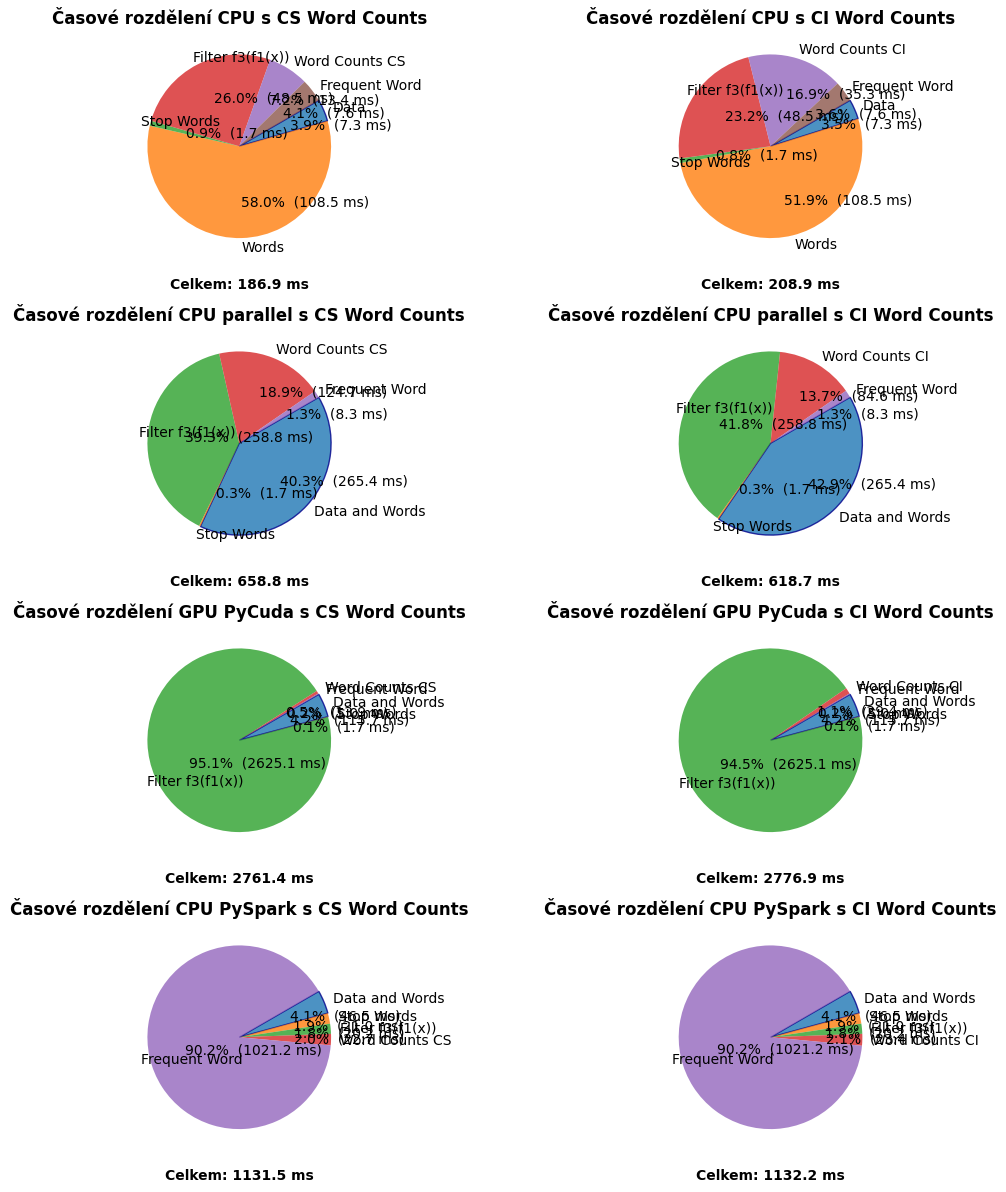

time: 1.64 s (started: 2023-12-23 18:43:59 +00:00)


In [114]:
# Vytvoření mřížky grafů
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# CPU
title = "Časové rozdělení CPU s CS Word Counts"
times = [time_CPU_data(), time_CPU_words(), time_CPU_stop_words(), time_CPU_filter31(), time_CPU_word_counts_CS(), time_CPU_frequent_word()]
labels = ['Data', 'Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[0][0], title, times, labels)

title = "Časové rozdělení CPU s CI Word Counts"
times = [time_CPU_data(), time_CPU_words(), time_CPU_stop_words(), time_CPU_filter31(), time_CPU_word_counts_CI(), time_CPU_frequent_word()]
labels = ['Data', 'Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[0][1], title, times, labels)

# CPU parallel
title = "Časové rozdělení CPU parallel s CS Word Counts"
times = [time_CPU_parallel_data_and_words(), time_CPU_stop_words(), time_CPU_parallel_filter31(), time_CPU_parallel_word_counts_CS(), time_CPU_parallel_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[1][0], title, times, labels)

title = "Časové rozdělení CPU parallel s CI Word Counts"
times = [time_CPU_parallel_data_and_words(), time_CPU_stop_words(), time_CPU_parallel_filter31(), time_CPU_parallel_word_counts_CI(), time_CPU_parallel_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[1][1], title, times, labels)

# GPU PyCuda
title = "Časové rozdělení GPU PyCuda s CS Word Counts"
times = [min(time_CPU_data() + time_CPU_words(), time_CPU_parallel_data_and_words()) , time_CPU_stop_words(),
         time_GPU_filter31_part1() + time_GPU_filter31_part2() + time_GPU_filter31_part3() + time_GPU_filter31_part4(),
         time_CPU_word_counts_CS_after_GPU(), time_CPU_frequent_word_after_GPU()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[2][0], title, times, labels)

title = "Časové rozdělení GPU PyCuda s CI Word Counts"
times = [min(time_CPU_data() + time_CPU_words(), time_CPU_parallel_data_and_words()) , time_CPU_stop_words(),
         time_GPU_filter31_part1() + time_GPU_filter31_part2() + time_GPU_filter31_part3() + time_GPU_filter31_part4(),
         time_CPU_word_counts_CI_after_GPU(), time_CPU_frequent_word_after_GPU()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[2][1], title, times, labels)

# Pyspark
title = "Časové rozdělení CPU PySpark s CS Word Counts"
times = [time_spark_data_and_words(), time_spark_stop_words(), time_spark_filter31(), time_spark_word_count_CS(), time_spark_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[3][0], title, times, labels)

title = "Časové rozdělení CPU PySpark s CI Word Counts"
times = [time_spark_data_and_words(), time_spark_stop_words(), time_spark_filter31(), time_spark_word_count_CI(), time_spark_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[3][1], title, times, labels)


plt.tight_layout()

# Zobrazení diagramu
plt.show()

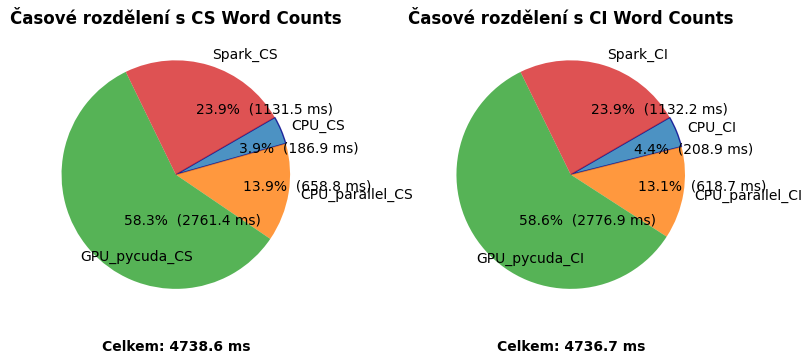

time: 293 ms (started: 2023-12-23 18:44:06 +00:00)


In [115]:
# Vytvoření mřížky grafů
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

title = "Časové rozdělení s CS Word Counts"
times = [sum_CPU_CS, sum_CPU_parallel_CS, sum_GPU_pycuda_CS, sum_spark_CS]
labels = ['CPU_CS', 'CPU_parallel_CS', 'GPU_pycuda_CS', 'Spark_CS']
plot_pie_chart(axs[0], title, times, labels)

title = "Časové rozdělení s CI Word Counts"
times = [sum_CPU_CI, sum_CPU_parallel_CI, sum_GPU_pycuda_CI, sum_spark_CI]
labels = ['CPU_CI', 'CPU_parallel_CI', 'GPU_pycuda_CI', 'Spark_CI']
plot_pie_chart(axs[1], title, times, labels)

plt.tight_layout()

# Zobrazení diagramu
plt.show()

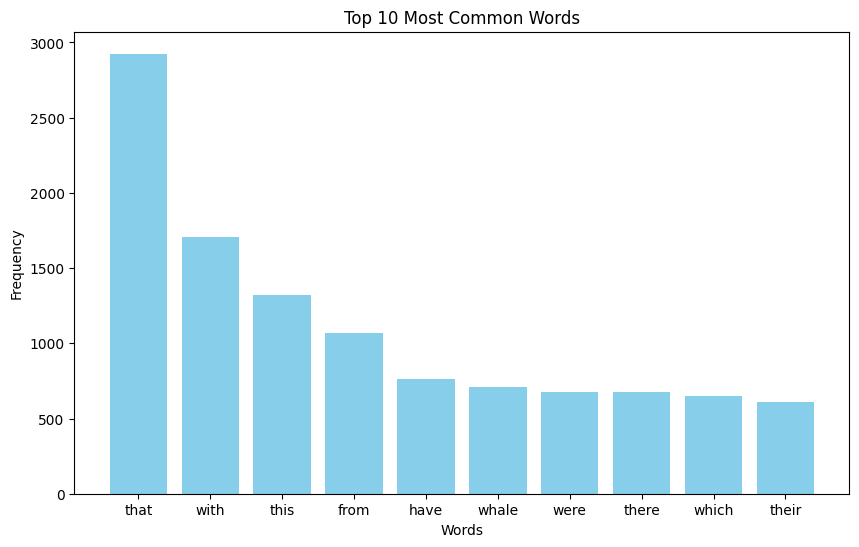

time: 235 ms (started: 2023-12-23 18:40:03 +00:00)


In [99]:
# Získání top 10 nejčastějších slov
num = 10
top_words = word_counts_for_graph.most_common(num)

# Extrahování dat pro graf
word_labels, words_counts = zip(*top_words)

# Vytvoření obdélníkového grafu
plt.figure(figsize=(10, 6))
plt.bar(word_labels, words_counts, color='skyblue')

# Přidání popisků a názvu
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')

# Zobrazení grafu
plt.show()

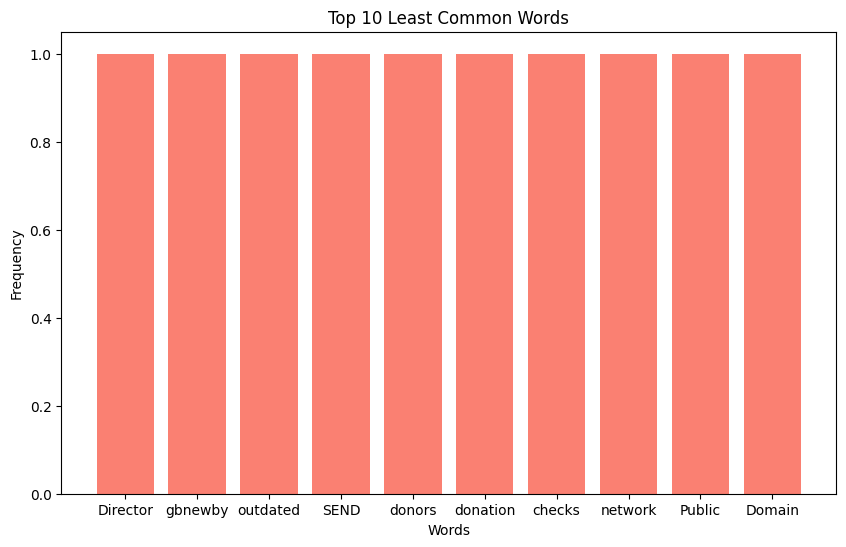

time: 249 ms (started: 2023-12-23 18:40:06 +00:00)


In [100]:
# Získání 10 nejméně častých slov
num = 10
bottom_words = word_counts_for_graph.most_common()[-1-num:-1]

# Extrahování dat pro graf
word_labels, words_counts = zip(*bottom_words)

# Vytvoření obdélníkového grafu
plt.figure(figsize=(10, 6))
plt.bar(word_labels, words_counts, color='salmon')

# Přidání popisků a názvu
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Least Common Words')

# Zobrazení grafu
plt.show()

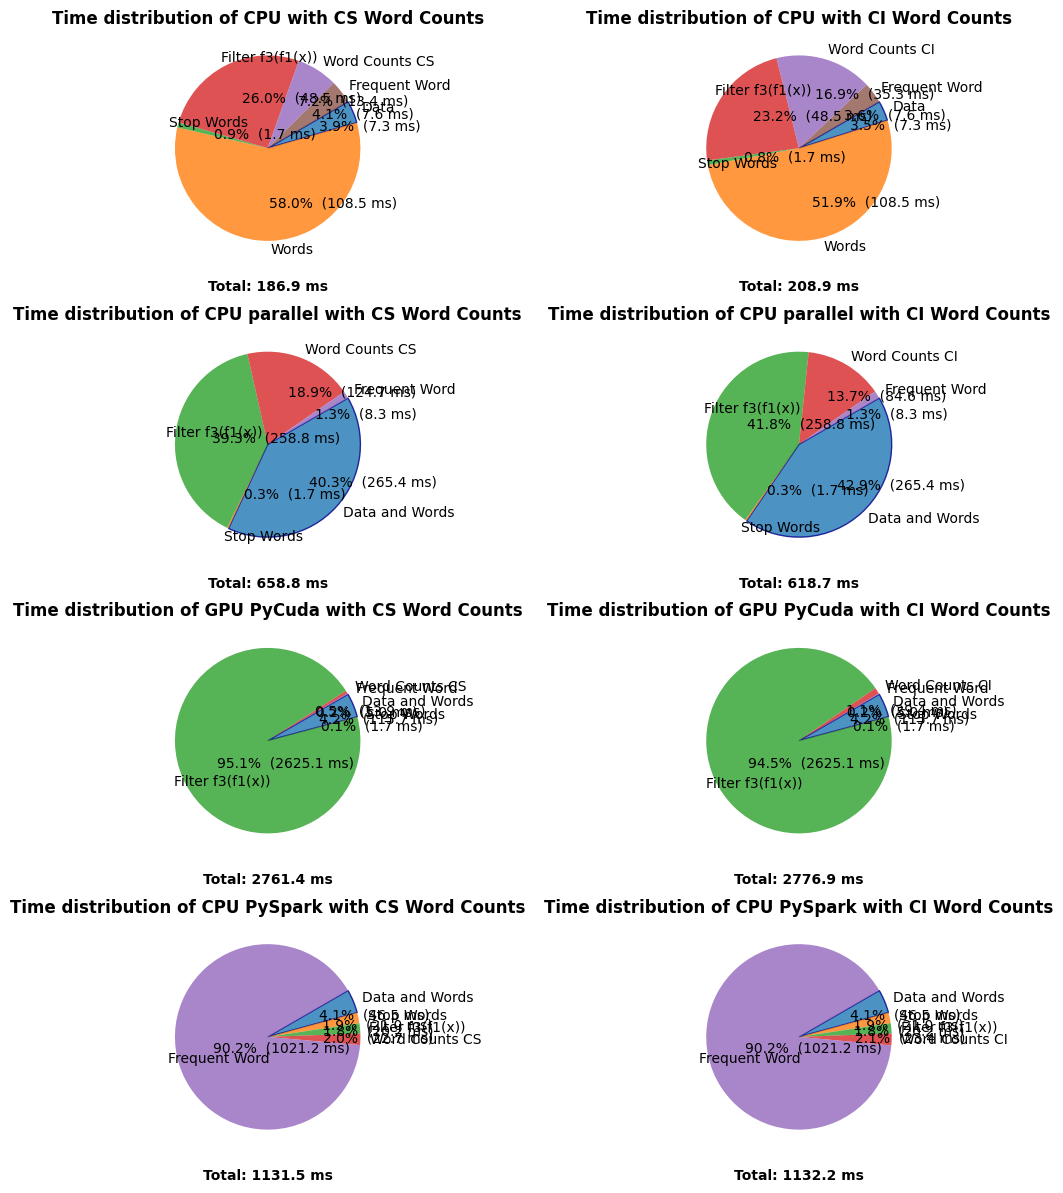

time: 1.09 s (started: 2023-12-23 19:03:21 +00:00)


In [118]:
# EN version

# Vytvoření mřížky grafů
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# CPU
title = "Time distribution of CPU with CS Word Counts"
times = [time_CPU_data(), time_CPU_words(), time_CPU_stop_words(), time_CPU_filter31(), time_CPU_word_counts_CS(), time_CPU_frequent_word()]
labels = ['Data', 'Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[0][0], title, times, labels)

title = "Time distribution of CPU with CI Word Counts"
times = [time_CPU_data(), time_CPU_words(), time_CPU_stop_words(), time_CPU_filter31(), time_CPU_word_counts_CI(), time_CPU_frequent_word()]
labels = ['Data', 'Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[0][1], title, times, labels)

# CPU parallel
title = "Time distribution of CPU parallel with CS Word Counts"
times = [time_CPU_parallel_data_and_words(), time_CPU_stop_words(), time_CPU_parallel_filter31(), time_CPU_parallel_word_counts_CS(), time_CPU_parallel_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[1][0], title, times, labels)

title = "Time distribution of CPU parallel with CI Word Counts"
times = [time_CPU_parallel_data_and_words(), time_CPU_stop_words(), time_CPU_parallel_filter31(), time_CPU_parallel_word_counts_CI(), time_CPU_parallel_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[1][1], title, times, labels)

# GPU PyCuda
title = "Time distribution of GPU PyCuda with CS Word Counts"
times = [min(time_CPU_data() + time_CPU_words(), time_CPU_parallel_data_and_words()) , time_CPU_stop_words(),
         time_GPU_filter31_part1() + time_GPU_filter31_part2() + time_GPU_filter31_part3() + time_GPU_filter31_part4(),
         time_CPU_word_counts_CS_after_GPU(), time_CPU_frequent_word_after_GPU()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[2][0], title, times, labels)

title = "Time distribution of GPU PyCuda with CI Word Counts"
times = [min(time_CPU_data() + time_CPU_words(), time_CPU_parallel_data_and_words()) , time_CPU_stop_words(),
         time_GPU_filter31_part1() + time_GPU_filter31_part2() + time_GPU_filter31_part3() + time_GPU_filter31_part4(),
         time_CPU_word_counts_CI_after_GPU(), time_CPU_frequent_word_after_GPU()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[2][1], title, times, labels)

# Pyspark
title = "Time distribution of CPU PySpark with CS Word Counts"
times = [time_spark_data_and_words(), time_spark_stop_words(), time_spark_filter31(), time_spark_word_count_CS(), time_spark_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CS', 'Frequent Word']
plot_pie_chart(axs[3][0], title, times, labels)

title = "Time distribution of CPU PySpark with CI Word Counts"
times = [time_spark_data_and_words(), time_spark_stop_words(), time_spark_filter31(), time_spark_word_count_CI(), time_spark_frequent_word()]
labels = ['Data and Words', 'Stop Words', 'Filter f3(f1(x))', 'Word Counts CI', 'Frequent Word']
plot_pie_chart(axs[3][1], title, times, labels)


plt.tight_layout()

# Zobrazení diagramu
plt.show()

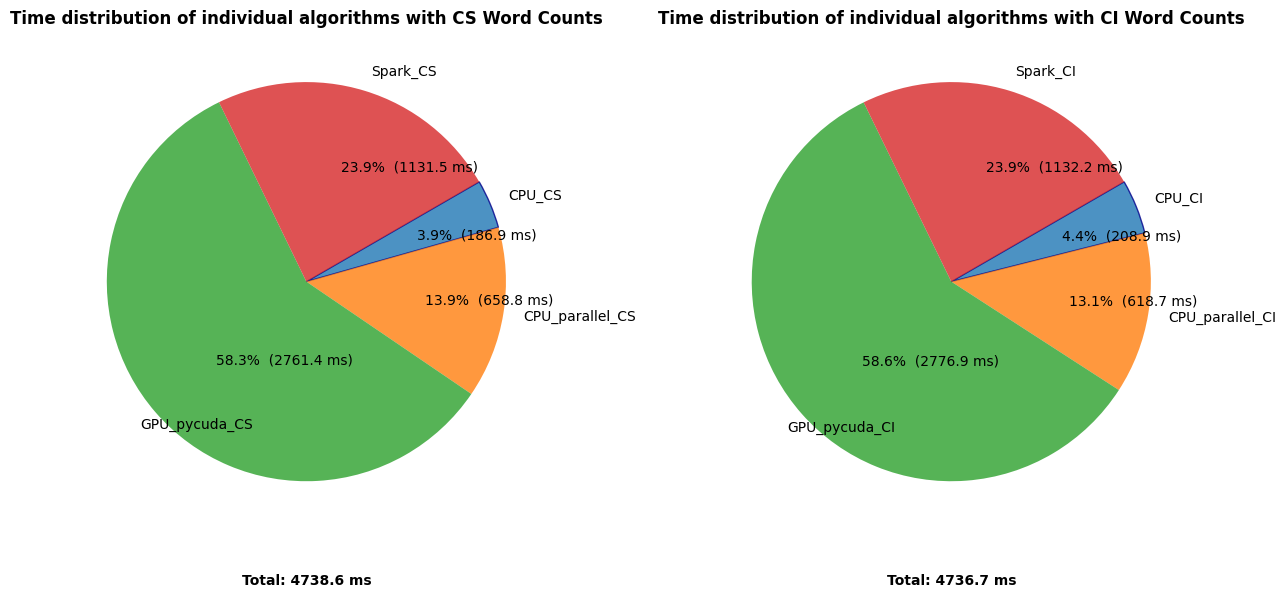

time: 665 ms (started: 2023-12-23 19:04:57 +00:00)


In [124]:
# Vytvoření mřížky grafů
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

title = "Time distribution of individual algorithms with CS Word Counts"
times = [sum_CPU_CS, sum_CPU_parallel_CS, sum_GPU_pycuda_CS, sum_spark_CS]
labels = ['CPU_CS', 'CPU_parallel_CS', 'GPU_pycuda_CS', 'Spark_CS']
plot_pie_chart(axs[0], title, times, labels)

title = "Time distribution of individual algorithms with CI Word Counts"
times = [sum_CPU_CI, sum_CPU_parallel_CI, sum_GPU_pycuda_CI, sum_spark_CI]
labels = ['CPU_CI', 'CPU_parallel_CI', 'GPU_pycuda_CI', 'Spark_CI']
plot_pie_chart(axs[1], title, times, labels)

plt.tight_layout()

# Zobrazení diagramu
plt.show()